In [70]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle


import os
import shutil
%matplotlib inline

Setup the directories for feed images, it will be train, and validation directories

In [30]:
DATA_DIR = "./DL3 Dataset"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/val"

NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(DATA_DIR + "/train_img/*.jpg")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.2)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.move(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.move(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.jpg"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.jpg"))
    print("Validation:",NUM_VAL_EXAMPLES )

directories already exist
Train: 10080
Validation: 2520


### Creating Inception Model


In [122]:
inception_model = InceptionV3(weights='imagenet', include_top=False)

img_width, img_height = 299, 299
top_epochs = 50
fit_epochs = 50
batch_size = 24

top_layers_checkpoint_path = 'cp.top.best.hdf5'
fine_tuned_checkpoint_path = 'cp.fine_tuned.best.hdf5'
new_extended_inception_weights = 'final_weights.hdf5'

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
prediction = Dense(85, activation='sigmoid')(x)

model = Model(input=inception_model.input, output=prediction)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

"""
Freeze all inception layers
"""
for layer in inception_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/Users/ram/miniconda3/envs/ml-dev/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [56]:
train_labels = pd.read_csv('./DL3 Dataset/meta-data/train.csv', index_col='Image_name')

def grouper(n, iterable, padvalue=None):
    g = cycle(zip(*[chain(iterable, repeat(padvalue, n-1))]*n))
    for batch in g:
        yield list(filter(None, batch))
 
 
def multilabel_flow(path_to_data, idg, bs=256, target_size=(32,32), train_or_valid='train'):
    gen = idg.flow_from_directory(path_to_data, batch_size=bs, target_size=target_size, classes=[train_or_valid], shuffle=False)
    names_generator = grouper(bs, gen.filenames)
    for (X_batch, _), names in zip(gen, names_generator):
        labels = [ train_labels.loc[n.split('/')[-1]] for n in names ]
        targets = np.array(labels)
        yield X_batch, targets
 


In [123]:
train_gen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.3,
    channel_shift_range=0.3,
    horizontal_flip=True)

test_gen = image.ImageDataGenerator(rescale=1./255)

train_generator = multilabel_flow(
                    DATA_DIR,
                    train_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='train')

validation_generator = multilabel_flow(
                    DATA_DIR,
                    test_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='val')

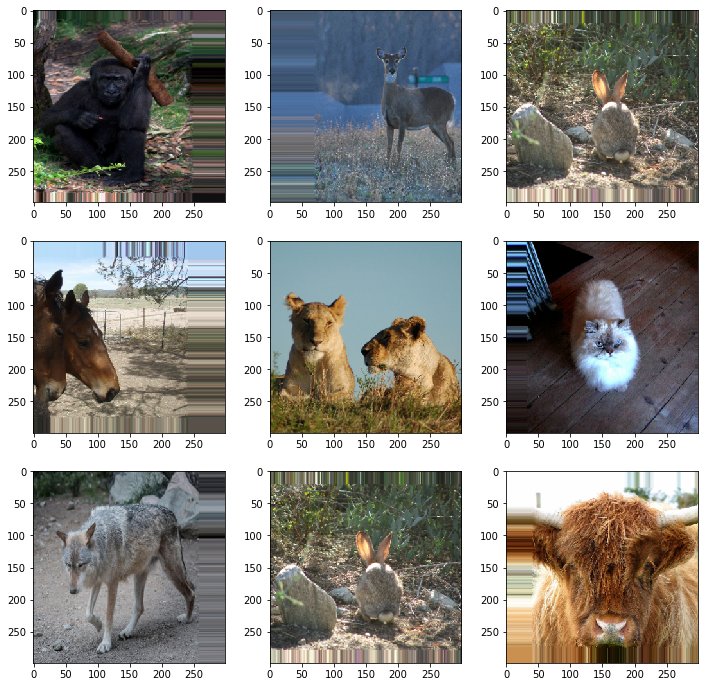

In [166]:
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
for i in range(9):
    draws[i].imshow(ss[0][random.randint(0, 23)])

In [ ]:
tb = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)
mc_top = ModelCheckpoint(top_layers_checkpoint_path,
                         monitor='val_acc', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)

                     

In [41]:

test_labels = pd.read_csv('./DL3 Dataset/meta-data/test.csv')
train_labels = train_labels.set_index('Image_name');

In [43]:
train_labels.shape

(12600, 85)

In [94]:
len(train_labels.loc['Image-22.jpg'].tolist())

85

In [101]:
y_train_ = np.array([train_labels.loc[label] for label in y_train])
y_test_ = np.array([train_labels.loc[label] for label in y_test])

In [125]:
preds = model.predict(X_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

result = preds.reshape(-1) == y_test_.reshape(-1)
acc_on_test = sum(result)/len(result)
print("Accuracy", acc_on_test)

Accuracy 0.976360877684407


### Test images from Hacker Earth

In [127]:
bottles = glob.glob('./features/test_img_vectors/*.txt')
X, y = features_from_bottles(bottles)

In [129]:
preds = model.predict(X)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [133]:
preds.shape

(5400, 85)

In [147]:
attribs = ['attrib_'+"{:02}".format(i) for i in range(1, 86)]

In [176]:
data = {}
for i in range(len(preds)):
    row = {a: int(b)  for (a,b) in zip(attribs, preds[i])}
    data[y[i]] = row

In [178]:
result = []
for val in test_labels['Image_name'].tolist():
    point_ = data[val]
    point_['Image_name'] = val
    result.append(point_)
    

In [181]:
df_preds = pd.DataFrame(result)
df_preds = df_preds.set_index('Image_name')

In [182]:
df_preds.head()

,attrib_01,attrib_02,attrib_03,attrib_04,attrib_05,attrib_06,attrib_07,attrib_08,attrib_09,attrib_10,...,attrib_76,attrib_77,attrib_78,attrib_79,attrib_80,attrib_81,attrib_82,attrib_83,attrib_84,attrib_85
Image_name,,,,,,,,,,,,,,,,,,,,,
Image-1.jpg,0,0,0,0,0,1,0,0,1,1,...,0,0,0,1,1,0,0,1,0,1
Image-2.jpg,0,1,0,1,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,1,1
Image-3.jpg,0,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
Image-4.jpg,1,0,0,0,1,1,1,0,0,1,...,0,1,1,1,0,0,0,0,0,0
Image-5.jpg,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0


In [183]:
df_preds.to_csv('result.csv')